# Imports

- Importando as bibliotecas necessárias:
    - `pandas` é importado para manipulação de dados.
    - `matplotlib.pyplot` é importado para visualização de dados.
    - `seaborn` é importado para visualização estatística de dados.
    - `train_test_split` é importado de `sklearn.model_selection` para dividir os dados em conjuntos de treinamento e teste.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Análise exploratória de dados

Antes de definir o que iremos fazer sobre os dados, será feito uma análise exploratória inicial. Para isso, vamos entender melhor os dados.
- Carregando os dados:
    - `pd.read_csv()` é usado para ler o arquivo CSV que contém os dados.
    - O caminho para o arquivo CSV é "/kaggle/input/crop-diseases-classification/Data/train.csv".
    - Os dados são armazenados em um DataFrame chamado `dsDiseases`.

In [2]:
dsDiseases = pd.read_csv("/kaggle/input/crop-diseases-classification/Data/train.csv")

Nessa primeira parte, vamos entender o que é cada coluna:
- Examinando as primeiras linhas do DataFrame:
    - `head()` é usado para visualizar as primeiras linhas do DataFrame `dsDiseases`.
    - Isso ajuda a ter uma ideia inicial da estrutura e dos dados presentes no DataFrame.

In [3]:
dsDiseases.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


Para uma visão ampla em relação aos dados, podemos plotar dois gráficos: um gráfico em barras (com a contagem de cada categoria) e um gráfico em pizza (com a porcentagem das categorias).
- Contagem e visualização das categorias:
    - `value_counts()` é usado para contar o número de ocorrências de cada categoria na coluna 'label' do DataFrame `dsDiseases`.
    - Os resultados são armazenados na variável `counts`.
    - Um gráfico de barras é criado usando `sns.barplot()` para visualizar a contagem de cada categoria.
    - `counts.index` é usado como os valores no eixo x (categorias).
    - `counts.values` é usado como os valores no eixo y (contagem).
    - O título do gráfico é definido como 'Crop diseases'.
    - Os rótulos dos eixos x e y são definidos como 'Categorias' e 'Contagem', respectivamente.
    - `plt.show()` é usado para exibir o gráfico.

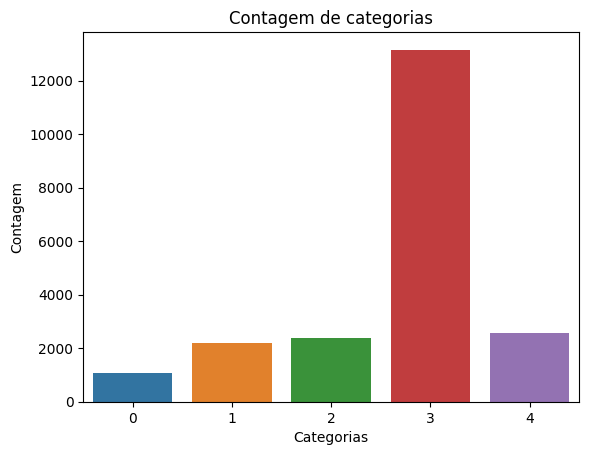

In [4]:
# Contagem das categorias
counts = dsDiseases['label'].value_counts()

# Plot
sns.barplot(x=counts.index, y=counts.values)
plt.title('Contagem de categorias')
plt.xlabel('Categorias')
plt.ylabel('Contagem')
plt.show()

- Visualização das categorias em um gráfico de pizza:
    - `plt.pie()` é usado para criar um gráfico de pizza com as porcentagens de cada categoria.
    - `counts` é passado como os dados para o gráfico de pizza.
    - `labels=counts.index` é usado para rotular as fatias do gráfico de acordo com as categorias.
    - `autopct='%1.1f%%'` formata as porcentagens exibidas em cada fatia.
    - `startangle=140` define o ângulo inicial da pizza para uma melhor visualização.
    - `plt.title()` define o título do gráfico como 'Crop diseases'.
    - `plt.axis('equal')` garante que a pizza seja desenhada como um círculo.
    - `plt.show()` é usado para exibir o gráfico de pizza.

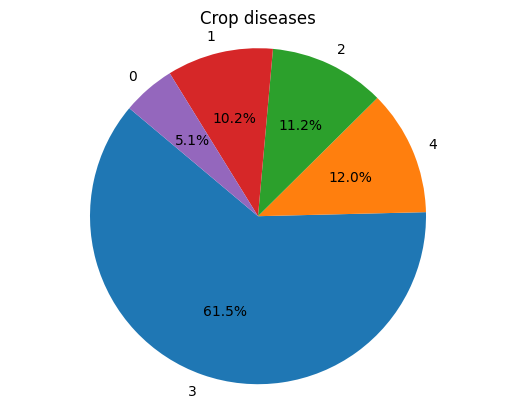

In [5]:
# Plot
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Crop diseases')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Divisão de treino, teste e validação

Bom, após vizualizarmos ambos os gráficos, percebemos que está desbalanceado, pois a categoria 3 possui 61.5% de amostras, o que é um valor maior do que a soma de todas as outras categorias, isso para um dataset não é bom, por isso vamos para a etapa de Divisão de treino, teste e validação de dados para o nosso dataset.

In [6]:
# Divisão dos dados em conjuntos de treinamento e teste, mantendo as amostras proporcionais
train_data, test_data = train_test_split(dsDiseases, test_size=0.2, random_state=42, stratify=dsDiseases['label'])

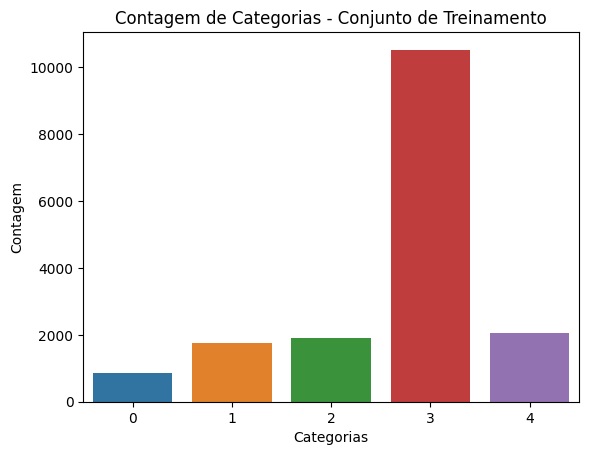

In [7]:
# Plot dos dados de treinamento
sns.barplot(x=train_data['label'].value_counts().index, y=train_data['label'].value_counts().values)
plt.title('Contagem de Categorias - Conjunto de Treinamento')
plt.xlabel('Categorias')
plt.ylabel('Contagem')
plt.show()

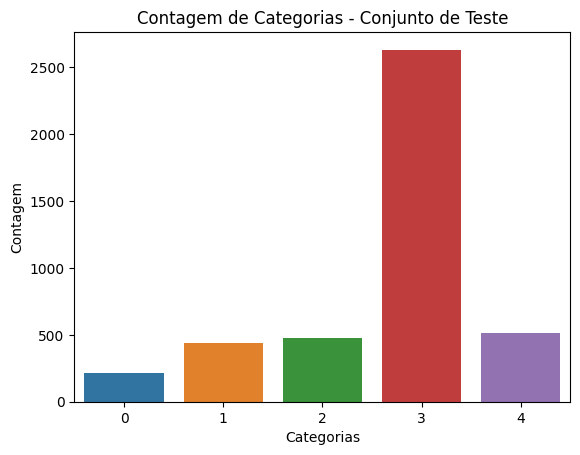

In [8]:
# Plot dos dados de teste
sns.barplot(x=test_data['label'].value_counts().index, y=test_data['label'].value_counts().values)
plt.title('Contagem de Categorias - Conjunto de Teste')
plt.xlabel('Categorias')
plt.ylabel('Contagem')
plt.show()

# Tratamento de dados

Técnicas de pré processamento acontecem dentro do dataset, antes de passar para o modelo, para que o dataset fique balanceado e tanto ele quanto o resultado seja justo.

Task:
Objetivo: Deixar todas as classes com a mesma quantidade. Aqui iremos deixar todas com o mesmo valor da classe 2, por ser a mediana.

- Classe 3 e 4: Recorte de dataset
    Será eliminado, de maneira aleatória, (classe3 - classe2) quantidades
    Motivo: Para diminuir a quantidade
- Classes 0 e 1: Data augmentation
    Motivo: Todas essas duas classes possuem uma amostragem muito menor. Sendo assim, iremos aumentar, através de técnicas de rotação e iluminação, os dados dessas classes. Com isso, teremos a mesma quantidade de dados da classe 2

# Normalização de dados

# Escolha modelo

# Treinamento

# Avaliação do modelo